In [2]:
import numpy as np
from sympy import symbols, Matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pylab as plt

In [3]:
tspan = np.linspace(0, 100, 100)

def sortEig(A):
    l, v = la.eig(A)
    idx = np.argsort(np.abs(l))
    l_sorted = l[idx]
    v_sorted = v[:, idx]
    return l_sorted, v_sorted

def ode_system(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    sum_n345 = n3 + n4 + n5
    CC_A = 1 - sum_n345 / KA
    CC_R = 1 - sum_n345 / KR
    dn1dt = - (R12 + R14)*n1
    dn2dt = R23*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3*CC_A - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4*CC_R - delta*n4
    dn5dt = R25*n2 - R45*n4 - R56*n5 + gamma5*n5*CC_R - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

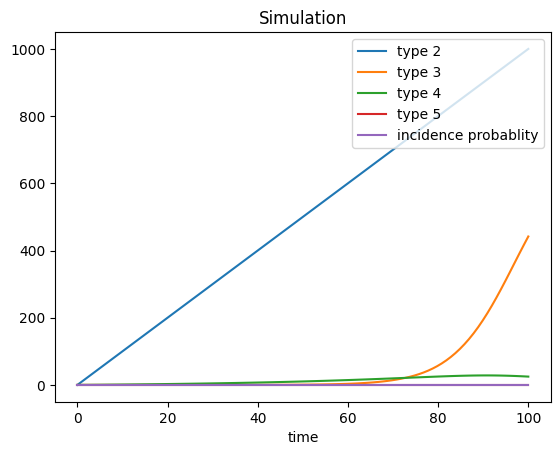

In [5]:
N_crypts = 1e+7
u = 10e-7
mu = 10e-9
gamma3 = 0.2
gamma4 = 0.077
gamma5 = 0.077
delta = 0.05
KA = 1000
KR = 600
sol = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

# plt.plot(sol.t, sol.y[0,:], label='1') # this is too big to plot
plt.plot(sol.t, sol.y[1,:], label="type 2") # linear growth
plt.plot(sol.t, sol.y[2,:], label="type 3")
plt.plot(sol.t, sol.y[3,:], label="type 4")
plt.plot(sol.t, sol.y[4,:], label="type 5")
plt.plot(sol.t, sol.y[5,:], label='incidence probablity')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.title("Simulation")
plt.savefig('figures/Simulation.png')
plt.show()

sensitivities matrix S =
 [[0.0000e+00 0.0000e+00 4.4444e-11 0.0000e+00 0.0000e+00 2.9629e-18]
 [0.0000e+00 0.0000e+00 6.6666e-06 0.0000e+00 0.0000e+00 4.4444e-13]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 6.6667e-08]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Max Value: 1.0
Max Position: (np.int64(2), np.int64(2))
elasticities matrix E =
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Max Value: (1+0j)
Max Position: (np.int64(2), np.int64(2))


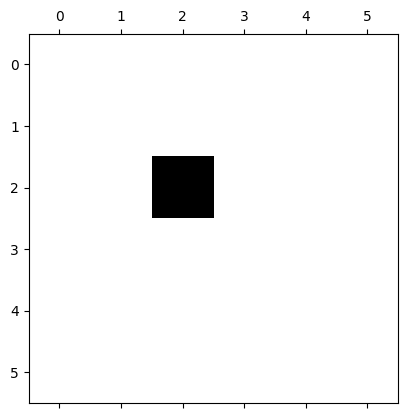

In [4]:
# Define the symbols used in the matrix
R12, R14, R23, R25, R36, R45, R56 = symbols('R12 R14 R23 R25 R36 R45 R56')
K_A, K_R, gamma_3, gamma_4, gamma_5, delta = symbols('K_A K_R gamma_3 gamma_4 gamma_5 delta')
n3, n4, n5, P = symbols('n3 n4 n5 P')

# Define A, B, and C as per the provided equations
A = -R36 + gamma_3 - (2 * gamma_3 * n3) / K_A - (gamma_3 * n4) / K_A - (gamma_3 * n5) / K_A - delta
B = -R45 + gamma_4 - (gamma_4 * n3) / K_R - (2 * gamma_4 * n4) / K_R - (gamma_4 * n5) / K_R - delta
C = -R56 + gamma_5 - (gamma_5 * n3) / K_R - (gamma_5 * n4) / K_R - (2 * gamma_5 * n5) / K_R - delta

# Define the matrix J
J = Matrix([
    [-R12 - R14, 0, 0, 0, 0, 0],
    [R23, -R23 - R25, 0, 0, 0, 0],
    [0, R23, A, -gamma_3 * n3 / K_A, -gamma_3 * n3 / K_A, 0],
    [R14, 0, -gamma_4 * n4 / K_R, B, -gamma_4 * n4 / K_R, 0],
    [0, R25, -gamma_5 * n5 / K_R, -R45 - gamma_5 * n5 / K_R, C, 0],
    [0, 0, R36 - R36 * P, 0, R56 - R56 * P, -R56 * n5 - R36 * n3]
])

# Display the original matrix J
# print("Matrix J:", J)

# Substitute n3, n4, n5, and P = 0 into the matrix (1st equilibrium points)
J_equilibrium = J.subs({n3: 0, n4: 0, n5: 0, P: 0})

# Display the evaluated matrix
# print("Evaluated Matrix J:", J_equilibrium)
values = {
    R12: 2*u, R14: mu, R23: u, R25: mu, R36: mu, R45: 2*u, R56: u, N_crypts: 1e7,
    K_A: 1000, K_R: 600, gamma_3: 0.2, gamma_4: 0.077, gamma_5: 0.077, delta: 0.05
}
J_result = np.array(J_equilibrium.subs(values).tolist(), dtype=float)

# compute sensitivity and elasticity matrix
l_right, v_right = sortEig(J_result)
v_right_max = v_right[:,-1]

l_left, v_left = sortEig(np.transpose(J_result))
v_left_max = v_left[:,-1]

np.set_printoptions(precision=4)
S = np.outer(v_left_max,v_right_max) / np.dot(v_left_max,v_right_max)
print("sensitivities matrix S =\n", np.real(S))

max_value_S = np.max(S)
max_position_S = np.unravel_index(np.argmax(S), S.shape)

print("Max Value:", max_value_S)
print("Max Position:", max_position_S)

E = S * J_result / l_left[-1]
print("elasticities matrix E =\n", np.real(E))

max_value_E = np.max(E)
max_position_E = np.unravel_index(np.argmax(E), E.shape)

print("Max Value:", max_value_E)
print("Max Position:", max_position_E)
plt.spy(np.real(E))

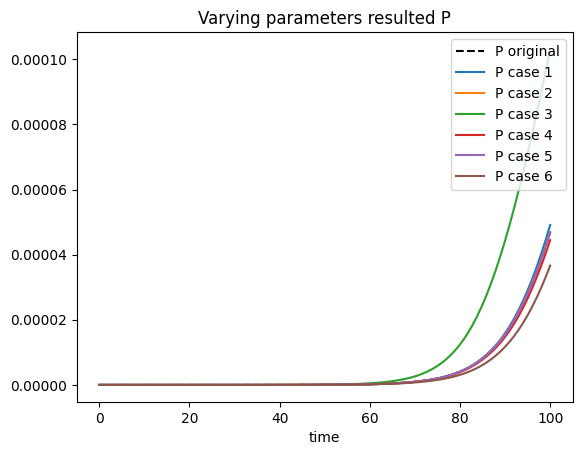

Case 1 SSE: 1.7488561328411905e-11
Case 2 SSE: 2.1721255485810032e-14
Case 3 SSE: 2.3972369409845553e-08
Case 4 SSE: 2.9858008477730836e-11
Case 5 SSE: 4.465086425273282e-15
Case 6 SSE: 5.972134581311365e-10
Max SSE occure at Case 3, with value : 2.3972369409845553e-08


In [6]:
# simulated variation in parameters 
N_crypts = 1e+7
u = 10e-7
mu = 10e-9
gamma3 = 0.2
gamma4 = 0.077
gamma5 = 0.077
delta = 0.05
KA = 1000
KR = 600

sol_1 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA+0.1*KA, KR, gamma3, gamma4, gamma5, delta))
sol_2 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR+0.1*KR, gamma3, gamma4, gamma5, delta))
sol_3 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3+0.1*gamma3, gamma4, gamma5, delta))
sol_4 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4+0.1*gamma4, gamma5, delta))
sol_5 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5+0.1*gamma5, delta))
sol_6 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR+100, gamma3, gamma4, gamma5, delta+0.1*delta))

plt.plot(sol.t, sol.y[5,:], label='P original', linestyle='--', color='black')
plt.plot(sol.t, sol_1.y[5,:], label='P case 1')
plt.plot(sol.t, sol_2.y[5,:], label='P case 2')
plt.plot(sol.t, sol_3.y[5,:], label='P case 3')
plt.plot(sol.t, sol_4.y[5,:], label='P case 4')
plt.plot(sol.t, sol_5.y[5,:], label='P case 5')
plt.plot(sol.t, sol_6.y[5,:], label='P case 6')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.title("Varying parameters resulted P")
plt.savefig('figures/Sensitivity.png')
plt.show()

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSE_dict = {}
for i, sol_case in enumerate([sol_1, sol_2, sol_3, sol_4, sol_5, sol_6], start=1):
    SSE_dict[f'Case {i}'] = np.sum((sol.y[5,:] - sol_case.y[5,:]) ** 2)

for case, sse in SSE_dict.items():
    print(f'{case} SSE: {sse}')
    
max_SSE_case = max(SSE_dict, key=SSE_dict.get)
max_SSE_value = SSE_dict[max_SSE_case]

print(f"Max SSE occure at {max_SSE_case}, with value : {max_SSE_value}")